#**Preprocessing** - Churn Prediction

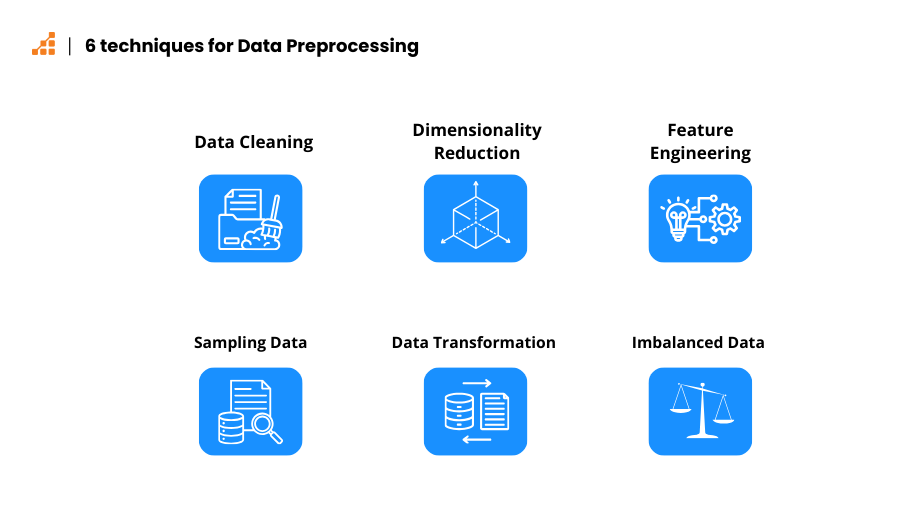

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder ,RobustScaler, StandardScaler,  MinMaxScaler ,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, accuracy_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

In [3]:
path="/content/drive/MyDrive/Mlops/telco.csv"
data = pd.read_csv(path)

#**Preprocessing and Imputation of Missing Data**

In [44]:
def preprocess_and_fill_missing(df, target_column, val_size=0.2):
    # Sélectionner les colonnes catégorielles (de type 'object' ou 'category') dans le DataFrame
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Retirer la colonne cible des colonnes catégorielles (car elle ne doit pas être encodée)
    categorical_columns.remove(target_column)

    # Appliquer la fonction pd.get_dummies pour encoder les colonnes catégorielles en variables indicatrices
    encoded_df = pd.get_dummies(df[categorical_columns], drop_first=True)

    # Remplacer les colonnes catégorielles d'origine par les colonnes encodées dans le DataFrame
    data = df.drop(columns=categorical_columns).join(encoded_df)

    # Créer un masque pour identifier les valeurs manquantes dans la colonne cible
    missing_mask = data[target_column].isnull()

    # Séparer les données en ensembles d'entraînement (sans valeurs manquantes) et de test (avec valeurs manquantes)
    X_train = data[~missing_mask].drop(target_column, axis=1)
    y_train = data[~missing_mask][target_column]
    X_test = data[missing_mask].drop(target_column, axis=1)

    # Diviser l'ensemble d'entraînement en sous-ensembles d'entraînement et de validation
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=val_size
    )
    print(f"Distribution des classes {target_column}  train:\n{y_train_split.value_counts()}\n")
    print(f"Distribution des classes  {target_column}  val:\n{y_val_split.value_counts()}\n\n")

    # Entraîner un modèle de classification (Random Forest)
    model = RandomForestClassifier()
    model.fit(X_train_split, y_train_split)

    # Prédire les valeurs manquantes dans la colonne cible
    predictions = model.predict(X_test)

    # Remplacer les valeurs manquantes par les prédictions obtenues
    data.loc[missing_mask, target_column] = predictions

    # Calculer l'exactitude du modèle sur l'ensemble de validation
    accuracy_val = accuracy_score(y_val_split, model.predict(X_val_split))
    print(f"Validation Accuracy of the model {target_column}: {accuracy_val:.2f}")

    return data

In [45]:
def preprocessing(data, cols_to_drop):
    # Supprimer les colonnes inutiles ou non pertinentes
    df_cleaned = data.drop(columns=cols_to_drop)

    # Sélectionner les colonnes numériques (de type 'float64' et 'int64')
    numerical_columns = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Normaliser les colonnes numériques en utilisant StandardScaler
    # scaler = StandardScaler()
    # df_cleaned[numerical_columns] = scaler.fit_transform(data[numerical_columns])

    # Normaliser les colonnes numériques en utilisant MinMaxScaler pour les ramener entre 0 et 1
    scaler = MinMaxScaler()
    df_cleaned[numerical_columns] = scaler.fit_transform(data[numerical_columns])

    # Identifier les colonnes contenant uniquement les valeurs 'Yes' et 'No'
    yes_no_columns = [col for col in df_cleaned.columns if df_cleaned[col].isin(['Yes', 'No']).all()]

    # Initialiser un label encoder pour convertir les colonnes 'Yes' et 'No' en 0 et 1
    label_encoder = LabelEncoder()
    for col in yes_no_columns:
        df_cleaned[col] = label_encoder.fit_transform(df_cleaned[col])

    # Identifier les colonnes catégorielles restantes
    categorical_columns = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()

    # Obtenir une liste des colonnes avec des valeurs manquantes
    columns_with_missing_values = df_cleaned.columns[df_cleaned.isnull().any()]

    # Initialiser une liste pour stocker les DataFrames après traitement des valeurs manquantes
    processed_dfs = []

    # Parcourir chaque colonne ayant des valeurs manquantes
    for col in columns_with_missing_values:
        # Créer un DataFrame temporaire avec uniquement la colonne à traiter
        temp_df = df_cleaned.drop([c for c in columns_with_missing_values if c != col ], axis=1)

        # Appliquer la fonction preprocess_and_fill_missing pour combler les valeurs manquantes
        preprocessed_df = preprocess_and_fill_missing(temp_df, col)

        # Ajouter le DataFrame traité à la liste
        processed_dfs.append(preprocessed_df)

    # Combiner tous les DataFrames traités en un seul
    final_df = processed_dfs[0]
    for df in processed_dfs[1:]:
        final_df = final_df.combine_first(df)

    # Supprimer les doublons s'il y en a
    if final_df.duplicated().sum() > 0:
        final_df = final_df.drop_duplicates()

    # Rechercher à nouveau les colonnes catégorielles après traitement
    categorical_columns = final_df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Encoder les colonnes catégorielles avec get_dummies
    encoded_df = pd.get_dummies(final_df[categorical_columns], drop_first=False)

    # Remplacer les colonnes catégorielles d'origine par les colonnes encodées
    df = final_df.drop(columns=categorical_columns).join(encoded_df)

    # Identifier les colonnes de type booléen et les convertir en entiers (0 ou 1)
    bool_columns = df.select_dtypes(include='bool').columns
    df[bool_columns] = df[bool_columns].astype(int)

    return df

In [46]:
cols_to_drop = ['Customer ID', 'Gender', 'Age','Zip Code', 'Latitude', 'Longitude','City', 'Churn Category','Churn Score','Churn Reason', 'Customer Status','Quarter','State','Country']

# cols_to_drop = [
#     'Customer ID', 'Gender', 'Age', 'Under 30','Zip Code', 'Latitude', 'Longitude','City','Total Charges', 'Country', 'State',
#     'Quarter', 'Phone Service', 'Multiple Lines', 'Online Backup',
#     'Device Protection Plan', 'Streaming TV', 'Streaming Movies',
#     'Streaming Music', 'Customer Status', 'Churn Category','Churn Reason'
# ]

df=preprocessing(data,cols_to_drop)

Distribution des classes Offer  train:
Offer
Offer E    659
Offer B    645
Offer D    472
Offer A    418
Offer C    338
Name: count, dtype: int64

Distribution des classes  Offer  val:
Offer
Offer B    179
Offer E    146
Offer D    130
Offer A    102
Offer C     77
Name: count, dtype: int64


Validation Accuracy of the model Offer: 1.00
Distribution des classes Internet Type  train:
Internet Type
Fiber Optic    2432
DSL            1329
Cable           652
Name: count, dtype: int64

Distribution des classes  Internet Type  val:
Internet Type
Fiber Optic    603
DSL            323
Cable          178
Name: count, dtype: int64


Validation Accuracy of the model Internet Type: 0.82


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Avg Monthly GB Download            7043 non-null   float64
 1   Avg Monthly Long Distance Charges  7043 non-null   float64
 2   CLTV                               7043 non-null   float64
 3   Churn Label                        7043 non-null   int64  
 4   Contract_One Year                  7043 non-null   int64  
 5   Contract_Two Year                  7043 non-null   int64  
 6   Dependents                         7043 non-null   int64  
 7   Device Protection Plan             7043 non-null   int64  
 8   Internet Service                   7043 non-null   int64  
 9   Married                            7043 non-null   int64  
 10  Monthly Charge                     7043 non-null   float64
 11  Multiple Lines                     7043 non-null   int64

In [48]:
df.isnull().sum()

,0
Avg Monthly GB Download,0
Avg Monthly Long Distance Charges,0
CLTV,0
Churn Label,0
Contract_One Year,0
Contract_Two Year,0
Dependents,0
Device Protection Plan,0
Internet Service,0
Married,0


Before Preprocessing :

In [49]:
data

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,20,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,0,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,0,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer
3,4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,...,0,494.00,2995.07,2,Churned,Yes,88,5337,Dissatisfaction,Limited range of services
4,4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,...,0,234.21,3102.36,2,Churned,Yes,67,2793,Price,Extra data charges
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,Female,30,No,No,No,No,0,United States,California,...,0,1639.44,3039.53,5,Stayed,No,45,5306,NaN,NaN
7039,6840-RESVB,Male,38,No,No,Yes,Yes,2,United States,California,...,0,865.20,2807.47,3,Stayed,No,59,2140,NaN,NaN
7040,2234-XADUH,Female,30,No,No,Yes,Yes,2,United States,California,...,0,2135.52,9453.04,4,Stayed,No,71,5560,NaN,NaN
7041,4801-JZAZL,Female,32,No,No,Yes,Yes,2,United States,California,...,0,0.00,319.21,4,Stayed,No,59,2793,NaN,NaN


After Preprocessing :

In [50]:
df

,Avg Monthly GB Download,Avg Monthly Long Distance Charges,CLTV,Churn Label,Contract_One Year,Contract_Two Year,Dependents,Device Protection Plan,Internet Service,Married,...,Under 30,Unlimited Data,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E
0,0.094118,0.000000,0.762731,1,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
1,0.200000,0.977195,0.733600,1,0,0,1,0,1,1,...,0,1,0,0,1,0,0,0,0,1
2,0.611765,0.226645,0.261508,1,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,0.141176,0.395279,0.741383,1,0,0,1,1,1,1,...,0,1,0,0,1,0,0,1,0,0
4,0.164706,0.126625,0.175673,1,0,0,1,0,1,1,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0.000000,0.455491,0.734490,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
7039,0.282353,0.721144,0.030465,0,1,0,1,1,1,1,...,0,1,1,0,0,0,0,1,0,0
7040,0.694118,0.593319,0.790972,0,1,0,1,1,1,1,...,0,1,0,0,1,1,0,0,0,0
7041,0.200000,0.000000,0.175673,0,0,0,1,0,1,1,...,0,1,0,1,0,0,0,0,1,0


In [51]:
missing_offer_rows = data[data['Offer'].isnull()]['Offer'].head(5)
missing_offer_rows

,Offer
0,NaN
16,NaN
23,NaN
24,NaN
25,NaN


In [52]:
# Trouver les colonnes contenant "Offer" dans leur nom
offer_columns = [col for col in df.columns if 'Offer' in col]
selected_rows = df.loc[[0, 16, 23, 24, 25], offer_columns]
selected_rows

,Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E
0,0,0,0,0,1
16,0,0,0,0,1
23,0,0,0,1,0
24,0,0,1,0,0
25,0,0,0,1,0


In [53]:
missing_Internet_Type_rows = data[data['Internet Type'].isnull()]['Internet Type']
missing_Internet_Type_rows

,Internet Type
25,NaN
41,NaN
199,NaN
373,NaN
375,NaN
...,...
7026,NaN
7027,NaN
7028,NaN
7034,NaN


In [54]:
# Trouver les colonnes contenant "Internet Type" dans leur nom
Internet_Type_columns = [col for col in df.columns if 'Internet Type' in col]
selected_rows = df.loc[[25,41,199,373,375,490,526,550,554,561], Internet_Type_columns]
selected_rows

,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic
25,0,1,0
41,0,1,0
199,1,0,0
373,1,0,0
375,0,1,0
490,0,1,0
526,0,1,0
550,0,1,0
554,0,1,0
561,0,1,0


In [55]:
df[df['Internet Type_Fiber Optic']==1]['Internet Type_Fiber Optic']

,Internet Type_Fiber Optic
1,1
2,1
3,1
4,1
5,1
...,...
7031,1
7035,1
7036,1
7040,1


In [56]:
df[df['Internet Type_Cable']==1]['Internet Type_Cable']

,Internet Type_Cable
14,1
20,1
23,1
24,1
32,1
...,...
7014,1
7019,1
7022,1
7037,1


In [65]:
# Séparer les données en X (features) et y (target)
X = df.drop(columns=['Churn Label'])
y = df['Churn Label']

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Save the training and testing data files to be used in testing later
df_train = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([X_test,y_test],axis=1)
df_train.to_csv("/content/drive/MyDrive/Mlops/data/train_data.csv",index=False)
df_test.to_csv("/content/drive/MyDrive/Mlops/data/test_data.csv",index=False)

In [66]:
print(f"Train size {df_train.shape}")
print(f"Test size {df_test.shape}")

Train size (5634, 44)
Test size (1409, 44)


#**Feature Selection**

In [59]:
def feature_selection_with_random_forest(df, target_column):
    # Split the data into features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Train a Random Forest model to assess feature importance
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Use SelectFromModel to select features based on importance
    selector = SelectFromModel(rf, threshold="mean", prefit=True)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Print selected features
    selected_features = X.columns[selector.get_support()]
    print(f"Selected features: {list(selected_features)}")

    return X_train_selected, X_test_selected, y_train, y_test

# Apply the function to your cleaned dataframe
X_train_selected, X_test_selected, y_train, y_test = feature_selection_with_random_forest(df, 'Churn Label')

Selected features: ['Contract_Two Year', 'Monthly Charge', 'Number of Referrals', 'Satisfaction Score', 'Tenure in Months', 'Total Charges', 'Total Long Distance Charges', 'Total Revenue']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [63]:
def feature_selection_with_mutual_info(df, target_column, num_features):
    # Split the data into features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Apply mutual information-based feature selection
    mi_selector = SelectKBest(score_func=mutual_info_classif, k=num_features)
    X_selected = mi_selector.fit_transform(X, y)

    # Get selected features
    selected_features = X.columns[mi_selector.get_support()]
    print(f"Selected features {len(list(selected_features))}: {list(selected_features)}")

    return X_selected, y

In [62]:
for i in range(1,21):
  X_selected, y = feature_selection_with_mutual_info(df, 'Churn Label', num_features=i)

Selected features 1: ['Satisfaction Score']
Selected features 2: ['Contract_Two Year', 'Satisfaction Score']
Selected features 3: ['Number of Referrals', 'Satisfaction Score', 'Tenure in Months']
Selected features 4: ['Contract_Two Year', 'Number of Referrals', 'Satisfaction Score', 'Tenure in Months']
Selected features 5: ['Contract_Two Year', 'Number of Referrals', 'Satisfaction Score', 'Tenure in Months', 'Internet Type_DSL']
Selected features 6: ['Contract_Two Year', 'Number of Referrals', 'Satisfaction Score', 'Tenure in Months', 'Total Long Distance Charges', 'Internet Type_DSL']
Selected features 7: ['Contract_Two Year', 'Monthly Charge', 'Number of Referrals', 'Satisfaction Score', 'Tenure in Months', 'Total Long Distance Charges', 'Internet Type_DSL']
Selected features 8: ['Contract_Two Year', 'Monthly Charge', 'Number of Referrals', 'Satisfaction Score', 'Tenure in Months', 'Total Long Distance Charges', 'Internet Type_DSL', 'Offer_Offer E']
Selected features 9: ['Contract_Tw

##**Handling Imbalanced Data with SMOTE**

In [ ]:
def apply_smote(df, target_column):
    # Séparer les données en X (features) et y (target)
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Séparer les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Initialiser SMOTE
    smote = SMOTE(random_state=42)

    # Appliquer SMOTE pour générer des exemples synthétiques pour la classe minoritaire
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    print(f"Distribution des classes avant SMOTE :\n{y_train.value_counts()} \n")
    print(f"Distribution des classes après SMOTE :\n{pd.Series(y_train_resampled).value_counts()}\n")

    return X_train_resampled, X_test, y_train_resampled, y_test

# Appliquer la fonction sur votre DataFrame nettoyé
X_train, X_test, y_train, y_test = apply_smote(data, 'Churn Label')

Distribution des classes avant SMOTE :
Churn Label
0    4165
1    1469
Name: count, dtype: int64
Distribution des classes après SMOTE :
Churn Label
1    4165
0    4165
Name: count, dtype: int64
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1009
           1       0.97      0.95      0.96       400

    accuracy                           0.98      1409
   macro avg       0.97      0.97      0.97      1409
weighted avg       0.98      0.98      0.98      1409



In [ ]:
churn_label_counts = y_test.value_counts()
print(churn_label_counts)

Churn Label
0    1009
1     400
Name: count, dtype: int64


In [ ]:
def test_balanced_sample(X_test, y_test):
    # Appliquer le sous-échantillonnage pour équilibrer l'échantillon de test
    sampler = RandomUnderSampler()
    churn_label_counts = y_test.value_counts()
    print("Original class distribution:")
    print(churn_label_counts)

    # Appliquer la méthode d'équilibrage sur les données de test
    X_test_balanced, y_test_balanced = sampler.fit_resample(X_test, y_test)
    churn_label_counts = y_test_balanced.value_counts()
    print("Balanced class distribution:")
    print(churn_label_counts)

    return X_test_balanced, y_test_balanced

X_test_balanced, y_test_balanced = test_balanced_sample(X_test, y_test)

Accuracy on original test set: 0.98
Balanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.99      0.95      0.98      0.97      0.94      1009
          1       0.97      0.95      0.99      0.96      0.97      0.93       400

avg / total       0.98      0.98      0.96      0.98      0.97      0.94      1409

Original class distribution:
Churn Label
0    1009
1     400
Name: count, dtype: int64
Balanced class distribution:
Churn Label
0    400
1    400
Name: count, dtype: int64
Accuracy on balanced test set: 0.97
Balanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.99      0.95      0.97      0.97      0.94       400
          1       0.99      0.95      0.99      0.97      0.97      0.93       400

avg / total       0.97      0.97      0.97      0.97      0.97      0.94       800

